# Giving geospatial context to a predictive model

## Business understanding
This is a short analysis to illustrate if adding the distance to an art galley, museum or other cultural center helps improve a model to predict the price you pay per night for your Airbnb. The Airbnb dataset used for this exercise was downloaded from the website [Inside Airbnb](http://insideairbnb.com/) and the inventory of cultural sites was downloaded from [Seattle's Open Data Portal](https://data.seattle.gov/). Using these publicly accessible datasets we will show how to give some spatial context to a dataset while trying to answer the following questions:

1. Are the neighborhoods with most expensive Airbnb prices per night the ones with the shortest average distance to cultural sites?
2. Does the variable 'distance' help create a more accurate predictive model?
3. Which are the most important variables for predicting price per night?

## Data understanding

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Import the Airbnb dataset
listings = pd.read_csv('data/listings.csv')
listings.head(3)
# listings.info()
# listings.shape

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [3]:

# Import the cultural sites dataset
cultural = pd.read_csv('data/Seattle_Cultural_Space_Inventory.csv')
cultural.head(3)
# cultural.info()
# cultural.shape

,Name,Phone,URL,Square Feet Total,Neighborhood,Organization Type,Dominant Discipline,Year of Occupation,Rent vs Own,Age of Current Building,...,Constituency over 50% one race,Specific Demographics and Community,Organization Leadership,Organization Artists,Closed Date,Closed?,Address,Location,Latitude,Longitude
0,Bootstrap Music,NaN,NaN,NaN,NaN,NaN,Studios,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Chinese Information and Service Center,NaN,NaN,NaN,NaN,NaN,Community Center,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,611 S Lane St Seattle WA 98104,"(47.596665, -122.325649)",47.596665,-122.325649
2,Gallery AXIS,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,308 1st Ave S,"(47.599804, -122.333995)",47.599804,-122.333995


In [4]:
# Verify null values on the listings dataset
listings[['price', 'latitude', 'longitude']].isna().sum()

price        0
latitude     0
longitude    0
dtype: int64

In [5]:
# Verify null values on the cultural dataset
cultural[['Latitude', 'Longitude']].isna().sum()

Latitude     32
Longitude    32
dtype: int64

The geographic coordinates fields (e.g. latitude, longitude) will be used to provide geospatial context to the dataset, so any null values need to be dropped on both datasets. There are other ways to fill these null values such as using the address stored, but that is out of scope in this short exercise.

## Data preparation

In [6]:
# Data cleaning (listings)
# Create a new column to store the 'price' as float
tmp_price = listings['price'].str.split('$', expand=True)
listings['price_cleansed'] = tmp_price[1].str.replace(',', '').astype('float')

# Data cleaning (cultural)
# Drop all rows with null in columns ['Latitude', 'Longitude']
cultural.dropna(subset=['Latitude', 'Longitude'], inplace=True)

In [7]:
# Create geodataframes and reproject them to UTM Zone 10N
gpd_airbnb = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude), crs='EPSG:4326').to_crs('EPSG:32610')
gpd_cultural = gpd.GeoDataFrame(cultural, geometry=gpd.points_from_xy(cultural.Longitude, cultural.Latitude), crs='EPSG:4326').to_crs('EPSG:32610')

In [8]:
# Join both geodataframes based on the closest cultural point
gpd_airbnb_cultural = gpd_airbnb.sjoin_nearest(gpd_cultural, distance_col="distance")
gpd_airbnb_cultural[['price_cleansed', 'distance']]

,price_cleansed,distance
0,85.0,510.173926
1,150.0,47.540641
3,100.0,262.710441
6,80.0,364.272624
9,150.0,224.897479
...,...,...
3793,109.0,504.657756
3732,65.0,347.697735
3733,125.0,65.873128
3781,55.0,183.272086


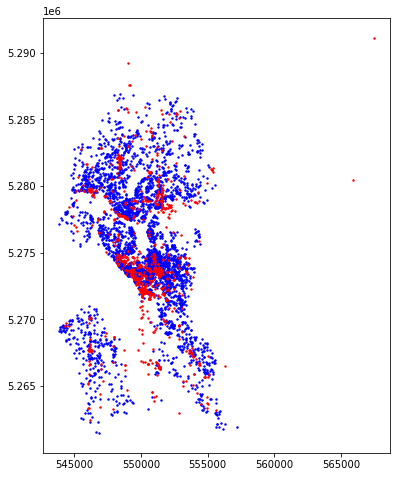

In [9]:
# Visualization
base = gpd_airbnb.plot(markersize=2, color="blue", figsize=(10,8))
gpd_cultural.plot(ax=base, markersize=2, color='red');

In [10]:
# Define variables of interest based on the data understanding
variables_of_interest = [
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'review_scores_rating',
    'cancellation_policy',
    'reviews_per_month',
    'distance',
    'price_cleansed']

# Subset dataset using the variables of interest
df = gpd_airbnb_cultural[variables_of_interest].copy()

Next, there is a function to fill null values in numeric fields using the average value of each column. This approach was taken to use as much data as possible. On the same vein, categorical fields will be transformed to dummy variables to be able to use them in the linear modeling process.

In [11]:
# Function to prepare the dataset
def prepare_data(df, y_column, include_distance=False):
    '''
    INPUT
    df - pandas dataframe 
    y_column - response variable
    include_distance - Bool
    
    OUTPUT
    X - variables to predict
    y - response vector
    '''

    # Response vector
    y = df[[y_column]]

    # Drop response columns
    if include_distance == False:
        df = df.drop([y_column, 'distance'], axis=1)
    else:
        df = df.drop(y_column, axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each variable add dummy one and drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # variables dataframe
    X = df
    
    return X, y


## Modeling

In [12]:
# Function to create a linear model, evaluate its accuracy, and extract its coefficient weights
def seattle_model(df, y_column, include_distance=False, test_size=0.3, random_state=1010):
    """
    INPUT
    df - pandas dataframe 
    y_column - response variable
    include_distance - Bool that defines if the model must include the 'distance' field
    test_size - fraction ot the dataset used for testing the model
    random_state - integer value used to create reproducible outputs
    
    OUTPUT
    coef_weights - linear model's coefficient weights
    """
    # Prepare the data
    X, y = prepare_data(df, y_column, include_distance)
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)

    # Create and fit the model
    lm_model = make_pipeline(StandardScaler(), LinearRegression())
    lm_model.fit(X_train, y_train)

    # Model prediction
    y_test_preds = lm_model.predict(X_test)
    # y_train_preds = lm_model.predict(X_train)

    # Print test r2 scores
    print('r2 score:', r2_score(y_test, y_test_preds))

    # Return model coefficient weights
    coef_weights = pd.DataFrame()
    coef_weights['Coefficient'] = lm_model.feature_names_in_
    coef_weights['Val'] = lm_model['linearregression'].coef_.T
    coef_weights['Abs_Val'] = np.abs(lm_model['linearregression'].coef_.T)
    coef_weights.set_index('Coefficient', inplace=True)
    return coef_weights

## Question 1: are the neighbourhoods with most expensive Airbnb prices per night the ones with the shortest average distance to cultural sites?

Other neighborhoods    836
Capitol Hill           583
Downtown               563
Name: neighbourhood_group_cleansed, dtype: int64


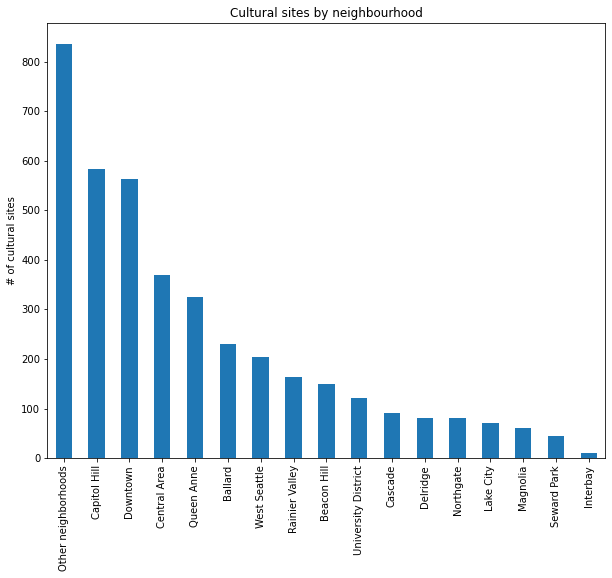

In [13]:
# Number of cultural sites by neighborhood
print(gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts()[:3])
gpd_airbnb_cultural['neighbourhood_group_cleansed'].value_counts().plot.bar(title='Cultural sites by neighbourhood', figsize=(10,8), xlabel='', ylabel='# of cultural sites');

neighbourhood_group_cleansed
Magnolia      177.672131
Queen Anne    157.466258
Downtown      154.470693
Name: price_cleansed, dtype: float64


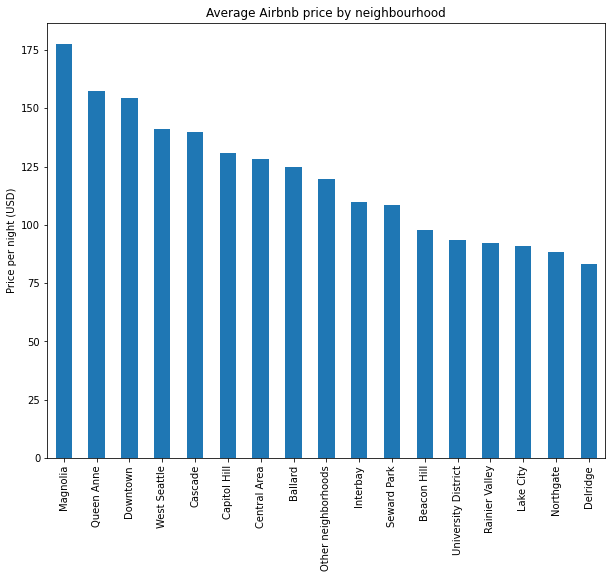

In [14]:
# Average Airbnb price by neighbourhood
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False)[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['price_cleansed'].mean().sort_values(ascending=False).plot.bar(title='Average Airbnb price by neighbourhood', figsize=(10,8), xlabel='', ylabel='Price per night (USD)');

neighbourhood_group_cleansed
Downtown                94.266945
University District    153.061736
Capitol Hill           216.085600
Name: distance, dtype: float64


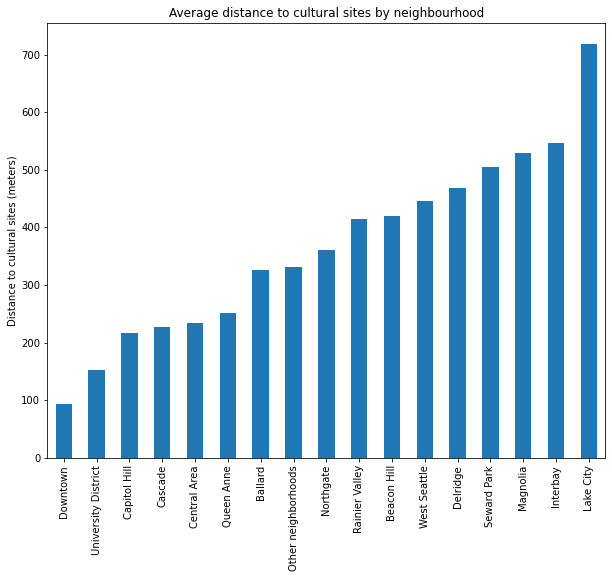

In [15]:
# Average distance to cultural sites by neighbourhood
print(gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values()[:3])
gpd_airbnb_cultural.groupby('neighbourhood_group_cleansed')['distance'].mean().sort_values().plot.bar(title='Average distance to cultural sites by neighbourhood', figsize=(10,8), xlabel='', ylabel='Distance to cultural sites (meters)');

These results show that the most expensive neighborhoods to rent an Airbnb do not have the shortest distance to cultural sites.

## Question 2: does the variable 'distance' help to create a more accurate predictive model?

In [16]:
# Compare r2 scores between both models
print("Linear model without the geospatial variable 'distance'")
coef_no_geospatial = seattle_model(df, 'price_cleansed', include_distance=False)
print("Linear model with the geospatial variable 'distance'")
coef_geospatial = seattle_model(df, 'price_cleansed', include_distance=True)

Linear model without the geospatial variable 'distance'
r2 score: 0.5291323860268592
Linear model with the geospatial variable 'distance'
r2 score: 0.5334407326167638


The model that uses the geospatial variable 'distance' performed slighly better than the model where this variable was not used to create the linear model. 

## Question 3: which are the most important variables for predicting price per night?

                          Abs_Val
Coefficient                      
bedrooms                25.887128
accommodates            24.230653
room_type_Private room  19.001645
bathrooms               18.608346
room_type_Shared room   12.571275
property_type_Boat       8.167986
availability_60          7.590217
reviews_per_month        6.234716
distance                 6.130939
review_scores_rating     5.114357


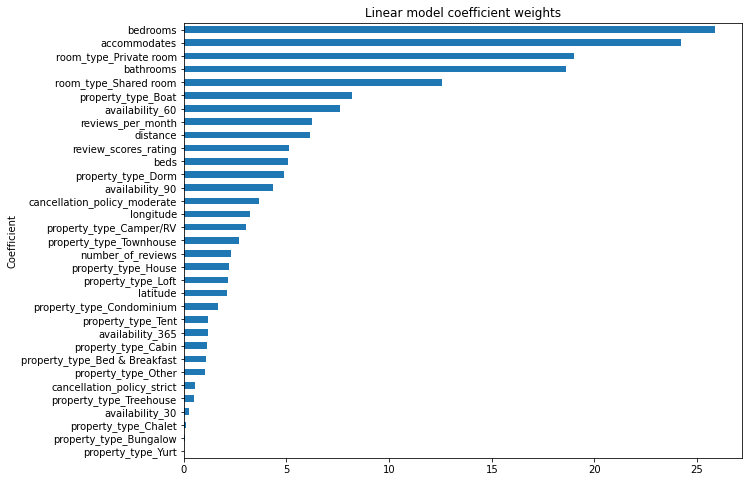

In [17]:
# Visualization of coefficient weights
print(coef_geospatial[['Abs_Val']].sort_values('Abs_Val', ascending=False)[:10])
coef_geospatial[['Abs_Val']].sort_values('Abs_Val').plot.barh(title='Linear model coefficient weights', figsize=(10,8), legend=False);

In addition to the list of variable seen in the table and figure above, it is important to note the variable 'distance' is in the top ten of importance. This suggests that this geospatial variable can be useful in this context with similar datasets. 

## Conclusions
Results of the first question show that neighbourhoods with the most expensive Airbnb rental price did not have the shortest distance to cultural, which implies there are variables more important to be used in the model to predict rental price. While this is true, 'distance' was ranked 9th in the linear model coefficient weights, which also suggest there is some level of usefulness in adding this sort of data derived from implicit geospatial characteristics of the dataset.

The geospatial variable 'distance' slightly improved the accuracy model, going from a r2-score of 0.529 up to 0.533. This small improvement seen in the model that used the geospatial variable could serve to increase awareness of the relevance of geospatial variables in some modeling scenarios and to encourage data scientists to add geospatial context to their analyses.